Lambda School Data Science

*Unit 4, Sprint 1, Module 3*

---

# Document Classification (Assignment)

This notebook is for you to practice skills during lecture.

Today's guided module project and assignment will be different. You already know how to do classification. You ready know how to extract features from documents. So? That means you're ready to combine and practice those skills in a kaggle competition. We we will open with a five minute sprint explaining the competition, and then give you 25 minutes to work. After those twenty five minutes are up, I will give a 5-minute demo an NLP technique that will help you with document classification (*and **maybe** the competition*).

Today's all about having fun and practicing your skills.

## Sections
* <a href="#p1">Part 1</a>: Text Feature Extraction & Classification Pipelines
* <a href="#p2">Part 2</a>: Latent Semantic Indexing
* <a href="#p3">Part 3</a>: Word Embeddings with Spacy
* <a href="#p4">Part 4</a>: Post Lecture Assignment

# Text Feature Extraction & Classification Pipelines (Learn)
<a id="p1"></a>

## Follow Along 

What you should be doing now:
1. Join the Kaggle Competition
2. Download the data
3. Train a model (try using the pipe method I just demoed)

In [1]:
import re
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report
from sklearn.decomposition import TruncatedSVD
import scipy.stats as stats
import spacy


from explore_data import get_num_words_per_sample 
from explore_data import plot_sample_length_distribution
from explore_data import plot_class_distribution
from explore_data import plot_frequency_distribution_of_ngrams
import seaborn as sns
sns.set()

import eli5

### Load Competition Datasklearn.metrics

In [2]:
# You may need to change the path
train = pd.read_csv('./whiskey-reviews-dspt7/train.csv')
test = pd.read_csv('./whiskey-reviews-dspt7/test.csv')
print(train.shape, test.shape)

(4087, 3) (1022, 2)


In [3]:
train.head()

,id,description,ratingCategory
0,1321,"\nSometimes, when whisky is batched, a few lef...",1
1,3861,\nAn uncommon exclusive bottling of a 6 year o...,0
2,655,\nThis release is a port version of Amrut’s In...,1
3,555,\nThis 41 year old single cask was aged in a s...,1
4,1965,"\nQuite herbal on the nose, with aromas of dri...",1


In [4]:
# Distribution of ratingCategory: 0 (Excellent), 1 (Good), 2 (Poor)
train.ratingCategory.value_counts(normalize=True)

1    0.704918
0    0.279178
2    0.015904
Name: ratingCategory, dtype: float64

In [5]:
# Set the options to show all of the value for each column
pd.set_option('display.max_colwidth', 0)

# Read a few reviews from the "Excellent" category
train[train.ratingCategory == 0].sample(3)

,id,description,ratingCategory
2265,4669,"\nHighland (Isle of Arran) single malt scotch Color: Straw Gold Aroma: Youthful. Pears in syrup, honeysuckle, and vanilla with a hint of caramel and citrus. Palate: Vibrant, somewhat youthful flavors that echo its aroma, finishing slightly sweet and a little fiery (because of its age). General Comments: The lack of chill-filtering certainly makes this whisky more flavorful and dynamic than its filtered brethren. It also tastes a little more mature. This shows how a whisky can be affected by chill-filtering. I expect this whisky to continue improving with additional aging. Available nationwide.",0
3639,4758,"\nInteresting: “Bottled by The Tennessee Spirits Company, Pewaukee, WI.” Woody nose, spiked with dry rye spiciness: black pepper, dried mint. My, that’s hot. It’s a rye rocket, and the wood’s drying up every bit of sweet here, leaving my tongue wrinkly. A bit of water, though, and this is a much happier whiskey; softer, sweeter notes come out, and the mint cheers up. (sourced whiskey)",0
409,107,"\nThis was my second lowest rated whiskey from the 2009 Collection (a 91 rating). This one is an impressive whiskey, and an improvement from last year. It’s soft (for a straight rye), well rounded, and easy to embrace, with tamed spice (cinnamon, mint, vanilla, mocha), nougat, toffee, fruit (bramble, subtle citrus), subtle date, and polished leather on the finish. Buffalo Trace is playing a shell game with this aged rye (being stored in stainless steel tanks over the past several years until new stocks mature), but in this instance there seems to be a prize under every shell. Well done! (Editor's Choice)",0


In [6]:
# Replace all numbers with #'s
train['description'] = [re.sub('\d', '#', i) for i in train['description']]

train.sample(5)

,id,description,ratingCategory
432,2803,"\nLabel: “BeanBall Bourbon – Tennessee Straight Bourbon Whiskey.” Believed to be from Dickel, but no confirmation; just the huge cracked corn component in the nose, which should be all you need. My, that’s tasty as it spreads like warm oil over the tongue, hot corn spirit spiked hard with oak. Good oak, dried corn, and a snap of mint in the finish. Nice selection…and interesting labeling in light of the recent Tennessee whiskey definition squabbles. Sourced whiskey.",1
3700,3014,"\nNew in ####, this is an NAS entry-level bottling for the brand, matured in bourbon barrels before spending a finishing period in oloroso sherry butts. Sweet and malty on the nose, a hint of mash, then pineapple. Becoming more floral, with violets. The palate offers soft fruit notes, cocoa powder, light sherry, and mixed nuts. The finish is medium in length, with milky coffee and soft spices.",1
3827,511,"\nJohnnie Walker Blue, meet Dewar’s Signature. Signature is Dewar’s introduction into the ultra-premium blended scotch category. Like Johnnie Walker Blue, Signature bears no age statement, but I’m told that a ## year old Aberfeldy is the heart of the blend. The first release consists only of #,### individually numbered bottles, and they’re only available in New York City. I’m always a little skeptical of very expensive blends that come in fancy packages. There are some very good, reasonably priced blends in the ##-## year old range, and the expensive ones are often only marginally better, if that. But I like this whisky a whole lot better than the standard Dewar’s White Label, and it is also superior to Dewar’s ## year old-a whisky which I find to be quite enjoyable. While maintaining the Dewar’s profile-nicely balanced-this whisky offers greater depth, maturity, and complexity without being too woody-a creamy, malty foundation makes sure of that. The whisky expresses a rich, honeyed maltiness which combines nicely with notes of golden raisins, vanilla, caramel, and crème brûlée, with just a hint of spicy oak notes for complexity. Signature is a different style when compared to Johnnie Walker Blue-it’s more elegant and bashful-but, like Blue, I put Signature on my short list of the finest blends on the market.",1
2117,889,"\nThis was matured entirely in sherry wood. Blackcurrants, black pepper, vanilla, caramel, and fruit spices on the nose. Supple on the malty palate, with red berry fruits, nutty sherry, and almonds. The finish is spicy, with black tea and firm oak.",1
283,2389,"\nThis expression of Jura is by leading London wine and spirits merchant Berry Bros. & Rudd, and was bottled in the company’s Berry’s Own range at ## years of age after maturation in sherry hogshead ####. The nose offers sweet sherry and caramel, sultanas, cinnamon, and rum baba, with an elusive wisp of smoke. Full-bodied, very fruity on the palate, with mixed spices, pine cones, and old sherry notes. The finish is long, nutty, and luxurious. £###",1


In [7]:
# Read a few reviews from the "Poor" category
train[train.ratingCategory == 2].sample(3)

,id,description,ratingCategory
1844,5065,"\nShowing its youth through an obvious green character that peers from beneath a cloak of campfire and applewood smoke, with banana as the prominent fruit, along with secondary apple, citrus, and a peculiar rubber tire note. The palate is light-bodied and overtly sweet, with grass, marshmallow, and vanilla. Reminiscent of a Lowland malt, which only contributes to the disjointed feeling of the whole package.",2
3120,5094,"\nIt does say “whisky” on the label...followed by “with natural cinnamon flavor.” It's clear from the first sniff that this is a one-trick pony: hot, fiery cinnamon. But is there whisky flavor in there? Fireball's as sweet as the liqueur proof would indicate, and as hot as advertised, and there's only a hint of whisky character under the fire. A novelty for tailgating; probably great in hot chocolate.",2
999,5076,"\nQuite pale in color. Very youthful and naked, with damp peat, leafy smoke, charred oak, and black licorice, pears in honey and vanilla-tinged barley. Quite an eye-opener for a non-Islay whisky. It’s a little green and ornery. Certainly an entertaining whisky, but a few more years in the barrel would round this whisky out, meld the flavors together, and add depth. \r\n",2


In [8]:
# Get the median words per sample
median_words = get_num_words_per_sample(train.description)
print(f'Median words per sample: {median_words}')

Median words per sample: 70.0


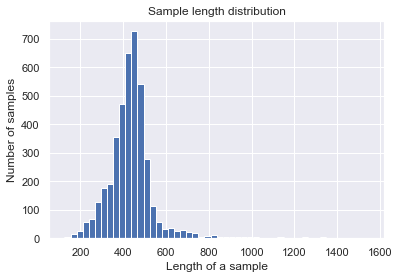

In [9]:
# Look at the lenght of characters in the data
plot_sample_length_distribution(train.description)

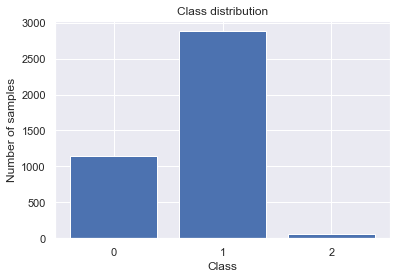

In [10]:
# Look at the distribution of the target
plot_class_distribution(train.ratingCategory)

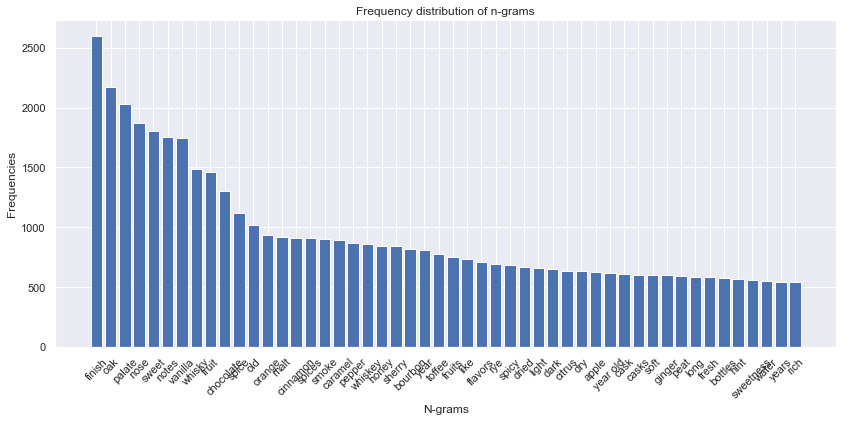

In [11]:
# Look at the count of the top 50 ngrams
plot_frequency_distribution_of_ngrams(train.description,
                                     ngram_range=(1, 2),
                                     num_ngrams=50)

In [12]:
# Get the ratio of the number of samples divided by the median words per sample 
sw_ratio = len(train.description.values) / median_words
print(f'Number of Samples / Median Words per Sample ratio: {int(sw_ratio)}')

Number of Samples / Median Words per Sample ratio: 58


### Split the Training Set into Train/Validation

In [13]:
X_train, X_test, y_train, y_test = train_test_split(train['description'], 
                                                    train['ratingCategory'], 
                                                    test_size=0.2, 
                                                    stratify=train['ratingCategory'],
                                                    random_state=42)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
X_train.head()

(3269,) (818,) (3269,) (818,)


1782    \nVery fragrant, with notes of fresh ripe plum, crisp spice, herbs, caramel, treacle, black pepper, and hints of dark chocolate. Leave the glass alone and the spices really hit their stride. The flavor shifts imperceptibly, covering citrus, vanilla, chocolate, and ripe orchard fruits, generating a slow build-up of spices like a gathering storm: your taste buds have nowhere left to run. Beautifully paced.                                                                             
3414    \nThe good news: This is one of the best Highland Park whiskies I have ever tasted. The bad news: it’s the new release for Travel Retail (formerly Duty Free). It’s lush, well-balanced, and very complex. Well-defined notes of toffee, candied fruit, and roasted nuts are accentuated by background honey, chocolate mousse, and smoke. Here’s the icing on the cake: it’s bottled at ##.#%, which really allows the flavors to shine. If you’re going overseas, consider tracking down a bottle.
2744    \nA sw

In [14]:
# Get the median words per sample on train set
median_words_train = get_num_words_per_sample(X_train)
print(f'Median words per sample: {median_words_train}')

Median words per sample: 70.0


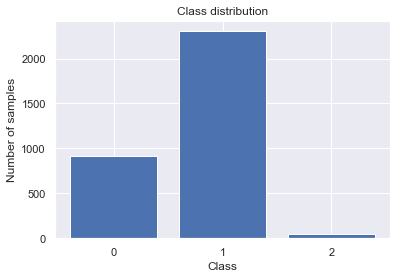

In [15]:
# Look at the distribution of the target
plot_class_distribution(y_train)

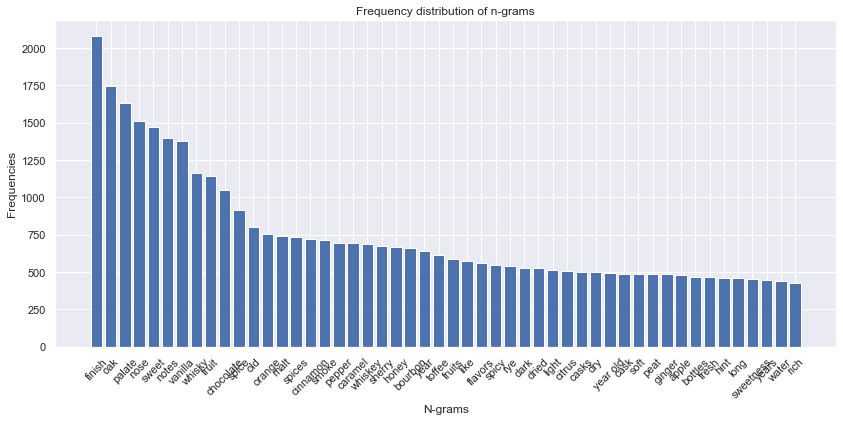

In [16]:
# Look at the count of the top 50 ngrams
plot_frequency_distribution_of_ngrams(X_train,
                                     ngram_range=(1, 2),
                                     num_ngrams=50)

### Define Pipeline Components

In [17]:
vect = TfidfVectorizer(stop_words='english', 
                       ngram_range=(1, 2))
clf = LinearSVC()

pipe = Pipeline([('vect', vect), ('clf', clf)])

In [18]:
# Get sparse dtm
dtm = vect.fit_transform(X_train)

# Convert that to a dataframe
dtm = pd.DataFrame(dtm.todense(), columns=vect.get_feature_names())
print(dtm.shape)
dtm.columns

(3269, 99767)


Index(['abandoned', 'abandoned antarctic', 'abate', 'abate mouth', 'abates',
       'abates bringing', 'aberdeen', 'aberdeen shire', 'aberdeenshire',
       'aberdeenshire distillery',
       ...
       'zuidam distillery', 'zuidam dutch', 'zuidam run', 'zuidam uses',
       'ànima', 'ànima negra', 'ìle', 'ìle bottles', 'ìle bottling',
       'ìle release'],
      dtype='object', length=99767)

### Define Your Search Space
You're looking for both the best hyperparameters of your vectorizer and your classification model. 

In [19]:
parameters = {
    'vect__max_df': (0.2, 0.3, 0.5, 0.6, 0.7),
    'vect__min_df': (2, 3, 6, 9),
    'vect__max_features': (6000, 7500, 9000),
    'clf__penalty': ('l1', 'l2'),
    'clf__C': (0.25, 0.3, 0.5, 0.6, 0.9)
}

grid_search = GridSearchCV(pipe, parameters, cv=5, n_jobs=4, verbose=1)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 600 candidates, totalling 3000 fits
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.9s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   23.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   53.8s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:  1.6min
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:  2.6min
[Parallel(n_jobs=4)]: Done 1792 tasks      | elapsed:  3.7min
[Parallel(n_jobs=4)]: Done 2442 tasks      | elapsed:  5.1min
[Parallel(n_jobs=4)]: Done 3000 out of 3000 | elapsed:  6.2min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('vect',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 2),
                                                        no

In [20]:
# Get the best score from grid search
grid_search.best_score_

0.752837292945755

In [21]:
# Get the best parameters
grid_search.best_params_

{'clf__C': 0.5,
 'clf__penalty': 'l2',
 'vect__max_df': 0.3,
 'vect__max_features': 9000,
 'vect__min_df': 2}

In [22]:
vect = TfidfVectorizer(stop_words='english', 
                       ngram_range=(1, 2))

clf = LinearSVC()

pipe = Pipeline([('vect', vect), ('clf', clf)])

In [1]:
parameters = {
    'vect__max_df': (0.3, 0.5, 0.6, 0.75, 0.8, 0.9),
    'vect__min_df': (2, 3, 5, 6, 8, 9, 12),
    'vect__max_features': (6000, 9000, 12000, 15000, 17000, 20000),
    'clf__penalty': ('l1', 'l2'),
    'clf__C': (0.1, 0.3, 0.5, 0.6, 0.75, 0.9, 1.25, 2.0)
}

grid_search = GridSearchCV(pipe, parameters, cv=5, n_jobs=8, verbose=1)
grid_search.fit(X_train, y_train)

NameError: name 'GridSearchCV' is not defined

In [24]:
# Look at the best score
print('Grid Search CV Best Score:', grid_search.best_score_, '\n')

# Look at the best parameters
print('Grid Search CV Best Parameters:', grid_search.best_params_, '\n')

# Evaluate on the test data
y_test_pred = grid_search.predict(X_test)
print('Grid Search CV Test Accuracy', accuracy_score(y_test, y_test_pred))

Grid Search CV Best Score: 0.754672155331076 

Grid Search CV Best Parameters: {'clf__C': 0.5, 'clf__penalty': 'l2', 'vect__max_df': 0.3, 'vect__max_features': 20000, 'vect__min_df': 2} 

Grid Search CV Test Accuracy 0.7481662591687042


In [25]:
# Look at the classification report:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.60      0.34      0.43       228
           1       0.78      0.93      0.84       577
           2       0.00      0.00      0.00        13

    accuracy                           0.75       818
   macro avg       0.46      0.42      0.43       818
weighted avg       0.71      0.75      0.72       818



In [26]:
# Extract the vectorizer and model from the grid search pipeline
best_mod = grid_search.best_estimator_
vect = best_mod.named_steps['vect']
clf = best_mod.named_steps['clf']

In [27]:
# Explain what each model learned about each class
eli5.show_weights(clf, vec=vect, top=100)

In [28]:
# Evaluate on the test data with the new parameters
y_test_pred = best_mod.predict(X_test)
accuracy_score(y_test, y_test_pred)

0.7481662591687042

### Make a Submission File
*Note:* In a typical Kaggle competition, you are only allowed two submissions a day, so you only submit if you feel you cannot achieve higher test accuracy. For this competition the max daily submissions are capped at **20**. Submit for each demo and for your assignment. 

In [29]:
# Predictions on test sample
pred = best_mod.predict(test['description'])

In [30]:
submission = pd.DataFrame({'id': test['id'], 'ratingCategory':pred})
submission['ratingCategory'] = submission['ratingCategory'].astype('int64')

In [31]:
# Make Sure the Category is an Integer
submission.head()

,id,ratingCategory
0,3461,1
1,2604,1
2,3341,1
3,3764,1
4,2306,1


In [32]:
subNumber = 5

In [33]:
# Save your Submission File
# Best to Use an Integer or Timestamp for different versions of your model

submission.to_csv(f'./whiskey-reviews-dspt7/submission{subNumber}.csv', index=False)
subNumber += 1

## Challenge

You're trying to achieve a minimum of 70% Accuracy on your model.

## Latent Semantic Indexing (Learn)
<a id="p2"></a>

## Follow Along
1. Join the Kaggle Competition
2. Download the data
3. Train a model & try: 
    - Creating a Text Extraction & Classification Pipeline
    - Tune the pipeline with a `GridSearchCV` or `RandomizedSearchCV`
    - Add some Latent Semantic Indexing (lsi) into your pipeline. *Note:* You can grid search a nested pipeline, but you have to use double underscores ie `lsi__svd__n_components`
4. Make a submission to Kaggle 


### Define Pipeline Components

In [34]:
vect = TfidfVectorizer(stop_words='english',
                      ngram_range=(1, 2),
                      min_df=2,
                      max_df=0.3,
                      max_features=7500)

svd = TruncatedSVD(algorithm='randomized', n_iter=10)

clf = RandomForestClassifier(random_state=42)

pipe = Pipeline([
    ('vect', vect),      # TF-IDF Vectorizer
    ('svd', svd),        # Truncated SVD Dimensionality Reduction
    ('clf', clf)         # RandomForest Classifier
])

params = {
    'svd__n_components': stats.randint(100, 7000)
}

In [35]:
# Fit the model
random_search = RandomizedSearchCV(pipe, params, cv=3, n_iter=5, n_jobs=-1, verbose=1)
random_search.fit(X_train, y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:  2.5min remaining:  2.2min
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  4.1min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('vect',
                                              TfidfVectorizer(analyzer='word',
                                                              binary=False,
                                                              decode_error='strict',
                                                              dtype=<class 'numpy.float64'>,
                                                              encoding='utf-8',
                                                              input='content',
                                                              lowercase=True,
                                                              max_df=0.3,
                                                              max_features=7500,
                                                              min_df=2,
                                                        

In [36]:
# Look at the best score
print('Random Search CV Best Score:', random_search.best_score_, '\n')

# Look at the best parameters
print('Random Search CV Best Parameters:', random_search.best_params_, '\n')

# Evaluate on the test data
y_test_rsv_pred = random_search.predict(X_test)
print('Random Search CV Test Accuracy', accuracy_score(y_test, y_test_rsv_pred))

Random Search CV Best Score: 0.7054147255148089 

Random Search CV Best Parameters: {'svd__n_components': 656} 

Random Search CV Test Accuracy 0.7053789731051344


### Define Your Search Space
You're looking for both the best hyperparameters of your vectorizer and your classification model. 

In [37]:
parameters = {
    'svd__n_components': [10, 100, 250],
    'vect__max_df': (0.3, 0.5, 0.6, 0.75, 0.9),
    'clf__max_depth':(5,10,15,20)
}

grid_search = GridSearchCV(pipe, parameters, cv=5, n_jobs=4, verbose=1)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   18.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  2.1min
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:  3.8min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('vect',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=0.3,
                                                        max_features=7500,
                                                        min_df=2,
                                                        ngram_range=(1, 2),
                                                        no

In [38]:
# Look at the best score
print('Grid Search Best Score:', grid_search.best_score_, '\n')

# Look at the best parameters
print('Grid Search Best Parameters:', grid_search.best_params_, '\n')

# Evaluate on the test data
y_test_gs_pred = grid_search.predict(X_test)
print('Grid Search Test Accuracy', accuracy_score(y_test, y_test_gs_pred))

Grid Search Best Score: 0.7277510057087729 

Grid Search Best Parameters: {'clf__max_depth': 10, 'svd__n_components': 10, 'vect__max_df': 0.3} 

Grid Search Test Accuracy 0.7237163814180929


### Make a Submission File

In [39]:
# Predictions on test sample
pred = grid_search.predict(test['description'])

In [40]:
submission = pd.DataFrame({'id': test['id'], 'ratingCategory':pred})
submission['ratingCategory'] = submission['ratingCategory'].astype('int64')

In [41]:
# Make Sure the Category is an Integer
submission.head()

,id,ratingCategory
0,3461,1
1,2604,1
2,3341,1
3,3764,1
4,2306,1


In [42]:
# Save your Submission File
# Best to Use an Integer or Timestamp for different versions of your model

submission.to_csv(f'./whiskey-reviews-dspt7/submission{subNumber}.csv', index=False)
subNumber += 1

## Challenge

Continue to apply Latent Semantic Indexing (LSI) to various datasets. 

# Word Embeddings with Spacy (Learn)
<a id="p3"></a>

## Follow Along

In [43]:
nlp = spacy.load('en_core_web_lg')

In [44]:
def get_word_vectors(docs):
    return [nlp(doc).vector for doc in docs]

In [45]:
X_train = get_word_vectors(X_train)
X_test = get_word_vectors(X_test)

In [46]:
from sklearn.ensemble import GradientBoostingClassifier

gbc = GradientBoostingClassifier(n_estimators=96, 
                                 max_depth=15,
                                 min_samples_leaf=13,
                                 random_state=42)

gbc.fit(X_train, y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=15,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=13, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=96,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=42, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [47]:
# Evaluate on test data
y_test_gbc_pred = gbc.predict(X_test)
accuracy_score(y_test, y_test_gbc_pred)

0.7493887530562348

### Make a Submission File

In [48]:
X_test2 = get_word_vectors(test['description'])

In [49]:
# Predictions on test sample
y_gbc_pred = gbc.predict(X_test2)

In [50]:
submission = pd.DataFrame({'id': test['id'], 'ratingCategory':y_gbc_pred})
submission['ratingCategory'] = submission['ratingCategory'].astype('int64')

In [51]:
# Make Sure the Category is an Integer
submission.head()

,id,ratingCategory
0,3461,1
1,2604,1
2,3341,1
3,3764,1
4,2306,1


In [52]:
# Save your Submission File
# Best to Use an Integer or Timestamp for different versions of your model
submission.to_csv(f'./whiskey-reviews-dspt7/submission{subNumber}.csv', index=False)
subNumber += 1

## Challenge

What you should be doing now:
1. Join the Kaggle Competition
2. Download the data
3. Train a model & try: 
    - Creating a Text Extraction & Classification Pipeline
    - Tune the pipeline with a `GridSearchCV` or `RandomizedSearchCV`
    - Add some Latent Semantic Indexing (lsi) into your pipeline. *Note:* You can grid search a nested pipeline, but you have to use double underscores ie `lsi__svd__n_components`
    - Try to extract word embeddings with Spacy and use those embeddings as your features for a classification model.
4. Make a submission to Kaggle 

In [89]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(solver='lbfgs',
                    alpha=1e-5,
                    hidden_layer_sizes=(30, 6),
                    random_state=97)

In [90]:
clf.fit(X_train, y_train)

MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(30, 6), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=97, shuffle=True, solver='lbfgs',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [91]:
y_test_mlp_pred = clf.predict(X_test)
accuracy_score(y_test, y_test_mlp_pred)

0.7432762836185819

## Make a Submission File


In [98]:
# Predictions on test sample
pred = clf.predict(get_word_vectors(test['description']))

In [99]:
submission = pd.DataFrame({'id': test['id'], 'ratingCategory':pred})
submission['ratingCategory'] = submission['ratingCategory'].astype('int64')

In [100]:
# Make Sure the Category is an Integer
submission.head()

,id,ratingCategory
0,3461,1
1,2604,1
2,3341,1
3,3764,1
4,2306,1


In [101]:
# Save your Submission File
# Best to Use an Integer or Timestamp for different versions of your model
submission.to_csv(f'./whiskey-reviews-dspt7/submission{subNumber}.csv', index=False)
subNumber += 1

# Post Lecture Assignment
<a id="p4"></a>

Your primary assignment this afternoon is to achieve a minimum of 70% accuracy on the Kaggle competition. Once you have achieved 70% accuracy, please work on the following: 

1. Research "Sentiment Analysis". Provide answers in markdown to the following questions: 
    - What is "Sentiment Analysis"? 
    - Is Document Classification different than "Sentiment Analysis"? Provide evidence for your response
    - How do create labeled sentiment data? Are those labels really sentiment?
    - What are common applications of sentiment analysis?
2. Research our why word embeddings worked better for the lecture notebook than on the whiskey competition.
    - This [text classification documentation](https://developers.google.com/machine-learning/guides/text-classification/step-2-5) from Google might be of interest
    - Neural Networks are becoming more popular for document classification. Why is that the case?